## #1 Business Understanding

1. Are there certain commodities preferred for production/price-increase?
2. If so, does the area of cultivation also show some relation to the price change (or any other relation that can be obtained)?
3. Since it is a known fact that commodities' price increases with time, is it possible to model this relation, along with other data (such as the province)?

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [110]:
df = pd.read_csv('32100364/32100364.csv',low_memory=False)
df.head()

,REF_DATE,GEO,DGUID,Estimates,Commodity,"Farm area, production, value",UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1926,Canada,2016A000011124,Marketed production,Fresh apples [114114111],Bushels,Bushels,42,thousands,3,v74253,1.1.1.1,8903.0,NaN,NaN,t,0
1,1926,Canada,2016A000011124,Marketed production,Fresh blueberries [1141114],Pounds,Pounds,254,thousands,3,v74308,1.1.2.3,0.0,NaN,NaN,t,0
2,1926,Canada,2016A000011124,Marketed production,Fresh grapes [1141147],Pounds,Pounds,254,thousands,3,v74391,1.1.3.3,24000.0,NaN,NaN,t,0
3,1926,Canada,2016A000011124,Marketed production,Fresh peaches [114114411],Bushels,Bushels,42,thousands,3,v74418,1.1.4.1,238.0,NaN,NaN,t,0
4,1926,Canada,2016A000011124,Marketed production,Fresh pears [114114211],Bushels,Bushels,42,thousands,3,v74439,1.1.5.1,275.0,NaN,NaN,t,0


### exploring data
the two functions below `blueberry_max_year_price` and `categorical_column_pieplot` are created to do some small level of data exploration
we do this to get a first look at the data we are working with

In [111]:
def blueberry_max_year_price(df):
    '''
    prints max_year,max_price values
    input:
        df: dataframe with geo,commodity,estimates columns
    '''
    df_bcbb = df.query('GEO == "British Columbia" & Commodity == "Fresh blueberries [1141114]" & Estimates == "Average price per pound"')
    (max_year,max_price) = (np.max(df_bcbb["REF_DATE"]),np.max(df_bcbb["VALUE"])) # we later derive this value using regression
    print(max_year,max_price)
blueberry_max_year_price(df)

1981 0.66


In [112]:
def categorical_column_pieplot(df,column_name,plot_title):
    '''
    draws pie plot for the column with column_name
    input:
        df: dataframe with column column_name
        column_name: column_name to plot
        plot_title: title of the plot
    '''
    axisplot = df[column_name].value_counts().plot
    pieplot = axisplot.pie()
    pieplot.set_ylabel('')
    pieplot.set_title(plot_title)

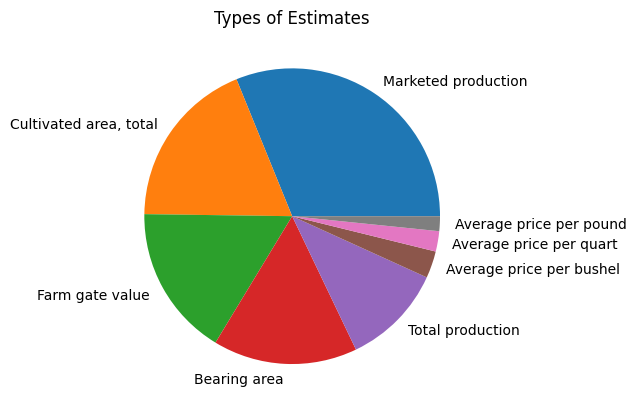

In [113]:
categorical_column_pieplot(df,'Estimates','Types of Estimates')

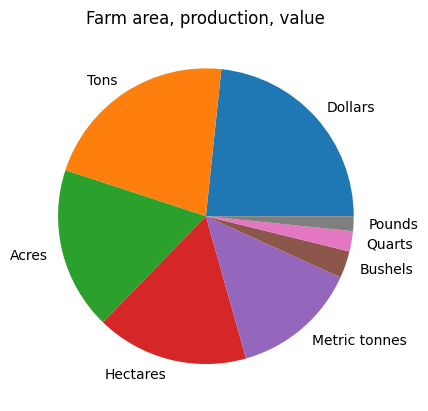

In [114]:
categorical_column_pieplot(df,'Farm area, production, value','Farm area, production, value')

### Understanding what the plots mean
The plots created above show value counts for two columns in the dataset - `estimates` and `farm area, production, value`. We can see how the values are distributed. We use the area of the plot to decide if we want to gather the corresponding data. For e.g. using the second plot, we gather the corresponding data for hectares, acres, tons, metric tonnes, dollars and pounds and ignore the quarts and bushels data. This could have been a textual representation, but the plot works fine as well.

## Functions for Data Cleaning

In [115]:
def drop_missing_by_column(df,column_name):
    '''
    drop rows with missing values in column_name
    input:
        df: dataframe with column column_name
        column_name: column_name for dropna
    '''
    return df.dropna(subset=[column_name],axis=0)

def drop_missing_all(df):
    '''
    drop rows if values are missing in all rows, or drop columns if values are missing in all columns
    input:
        df: dataframe to clean
    '''
    df.dropna(how='all',axis=1,inplace=True)
    df.dropna(how='all',axis=0,inplace=True)
    return df

def drop_extra_columns(df,columns):
    '''
    drop extra columns
    input:
        df: dataframe to clean
    '''
    drop_cols = ['Estimates','Farm area, production, value','UOM','SCALAR_FACTOR','DECIMALS']
    drop_cols.extend(['DGUID','UOM_ID','COORDINATE','VECTOR','SCALAR_ID'])
    drop_cols.extend(columns)
    df.drop(drop_cols,axis=1,inplace=True)
    return df

def drop_geo_values(df,geo=[]):
    '''
    drop dataframes with geo values
    input:
        geo: geo values to drop
    '''
    for geo_value in geo:
        df = df[df['GEO'] != geo_value]
    return df

def concat_rows(*dataframes):
    '''
    concatenate dataframes along rows
    input:
        dataframes: dataframes to concatenate
    '''
    return pd.concat(dataframes,axis=0,ignore_index=True)

## Functions for Data Preparation

In [116]:
def hectare_to_acre(df,column_name):
    '''
    convert hectare to acre
    input:
        df: dataframe with hectare value
        column_name: column column_name with value in hectare
    '''
    df['VALUE_acre'] = df[column_name] * 2.47105
    df.drop(column_name,inplace=True,axis=1)
    df.rename(columns={'VALUE_acre':column_name},inplace=True)
    return df

def pounds_to_kg(df,column_name):
    '''
    convert pounds to kg
    input:
        df: dataframe with pound value
        column_name: column column_name with value in pound
    '''
    df['VALUE_kg'] = df_pounds[column_name] * 0.453592
    df.drop(column_name,inplace=True,axis=1)
    df.rename(columns={'VALUE_kg':column_name},inplace=True)
    return df

def tons_to_kg(df,column_name):
    '''
    convert tons to kg
    input:
        df: dataframe with tons value
        column_name: column column_name with value in tons
    '''
    df['VALUE_kg'] = df['VALUE'] * 907.185
    df.drop(column_name,inplace=True,axis=1)
    df.rename(columns={'VALUE_kg':column_name},inplace=True)
    return df

def mtonnes_to_kg(df,column_name):
    '''
    convert metric tonnes to kg
    input:
        df: dataframe with metric tonnes value
        column_name: column column_name with value in metric tonnes
    '''
    df['VALUE_kg'] = df['VALUE'] * 1000
    df.drop(column_name,inplace=True,axis=1)
    df.rename(columns={'VALUE_kg':column_name},inplace=True)
    return df

## #2 Data Gathering
In the following cells (1-3 and 4 separately for gathering), we gather the necessary data so that we can later make predictions on price (or area, weight).
In addition to this, we also need these values for creating visualizations.

### 1. Gathering farm area (in acres)
we gather dataframe to get area values, some cleaning of the data is also done here

In [117]:
df_hectare = df[df['Farm area, production, value'] == 'Hectares']
df_acre = df[df['Farm area, production, value'] == 'Acres']

df_hectare = drop_missing_by_column(df_hectare,'VALUE')
df_acre = drop_missing_by_column(df_acre,'VALUE')

hectare_to_acre(df_hectare,'VALUE')

df_acre = concat_rows(df_hectare,df_acre)

### 2. Gathering commodities weight (in kg)
we gather dataframe to get weight values, some cleaning of the data is also done here

In [118]:
df_pounds = df[df['Farm area, production, value'] == 'Pounds']
df_tons = df[df['Farm area, production, value'] == 'Tons']
df_mtonnes = df[df['Farm area, production, value'] == 'Metric tonnes']

df_pounds = drop_missing_by_column(df_pounds,'VALUE')
df_tons = drop_missing_by_column(df_tons,'VALUE')
df_mtonnes = drop_missing_by_column(df_mtonnes,'VALUE')

pounds_to_kg(df_pounds,'VALUE')
tons_to_kg(df_tons,'VALUE')
mtonnes_to_kg(df_mtonnes,'VALUE')

df_kg = concat_rows(df_pounds,df_tons,df_mtonnes)

### sidebar for hypothesis
by looking at the data in this manner using `groupby`, we see that certain commodities have greater production weight (in kg) than others - and when we combine the weight
of the commodity with the geo, we notice that the distribution varies; similarly we can model such a relationship for the price (in dollars) - which we do later

<AxesSubplot: ylabel='GEO,Commodity'>

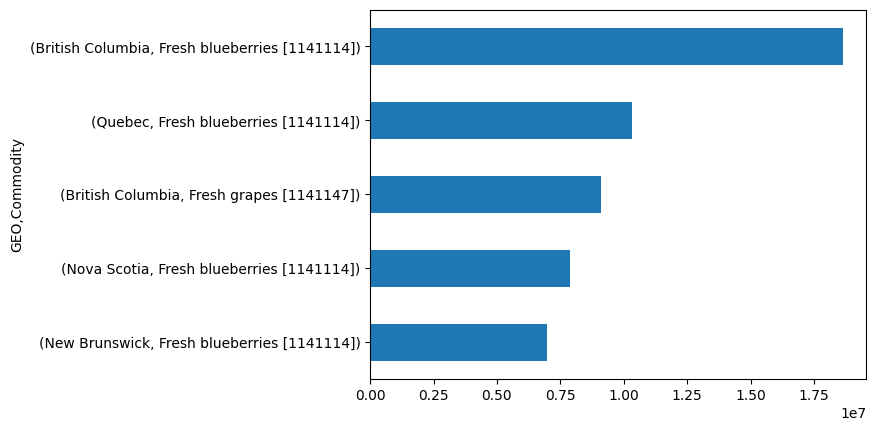

In [119]:
df_kg_plot = df_kg[(df_kg['Commodity']=='Fresh blueberries [1141114]') | (df_kg['Commodity']=='Fresh grapes [1141147]')]
df_kg_plot.groupby(['GEO','Commodity'])['VALUE'].agg(np.mean).sort_values(ascending=True)[15:20].plot.barh()

### Understanding what the plot means
The plot created above is generated using `groupby` and combines production (in weight) with the geo. We do this to study the distribution of the commodity in a province - by taking its `mean` and then sorting in a descending order.

### 3. Gathering price value (in dollars)
we gather dataframe to get price values, some cleaning of the data is also done here

In [120]:
df_dollars = df[(df['Estimates'] == 'Average price per pound') & (df['UOM'] == 'Dollars')]

df_dollars = drop_missing_by_column(df_dollars,'VALUE')

In [93]:
df_dollars.groupby(['Commodity','GEO'])['VALUE'].agg(np.mean).sort_values(ascending=False)

Commodity                    GEO                      
Fresh blueberries [1141114]  British Columbia             0.151964
                             Quebec                       0.143750
                             Canada                       0.136400
                             Nova Scotia                  0.114107
                             New Brunswick                0.113393
                             Atlantic provinces           0.109643
                             Prince Edward Island         0.109286
                             Newfoundland and Labrador    0.084821
Fresh grapes [1141147]       British Columbia             0.071964
                             Canada                       0.055000
                             Ontario                      0.053393
Name: VALUE, dtype: float64

## #3 Cleaning Data
In the following cells (a-c) we clean the data, by dropping the necessary columns or removing nan values

### a. cleaning area dataframe

In [94]:
# following geos do not exist for area related data, still calling the geo clean function to hint further refactoring
df_acre = drop_geo_values(df_acre,geo=['Maritime provinces','Atlantic provinces'])
df_acre = drop_missing_all(df_acre)
df_acre = drop_extra_columns(df_acre,columns=['STATUS'])

df_acre.head()

,REF_DATE,GEO,Commodity,VALUE
0,2002,Canada,Fresh apples [114114111],60595.08810
1,2002,Canada,Fresh blueberries [1141114],123945.39695
2,2002,Canada,Fresh grapes [1141147],26104.17220
3,2002,Canada,Fresh nectarines [114114421],1060.08045
4,2002,Canada,Fresh peaches [114114411],8055.62300


### b. cleaning weight dataframe

In [95]:
df_kg = drop_geo_values(df_kg,geo=['Maritime provinces','Atlantic provinces'])
df_kg = drop_missing_all(df_kg)
df_kg = drop_extra_columns(df_kg,columns=['TERMINATED','STATUS'])

df_kg.head()

,REF_DATE,GEO,Commodity,VALUE
0,1926,Canada,Fresh blueberries [1141114],0.000
1,1926,Canada,Fresh grapes [1141147],10886.208
3,1926,Newfoundland and Labrador,Fresh blueberries [1141114],0.000
4,1926,Prince Edward Island,Fresh blueberries [1141114],0.000
5,1926,Nova Scotia,Fresh blueberries [1141114],0.000


### c. cleaning price dataframe

In [96]:
df_dollars = drop_geo_values(df_dollars,geo=['Maritime provinces','Atlantic provinces'])
df_dollars = drop_missing_all(df_dollars)
df_dollars = drop_extra_columns(df_dollars,columns=['TERMINATED'])

df_dollars.head()

,REF_DATE,GEO,Commodity,VALUE
10,1926,Canada,Fresh blueberries [1141114],0.00
11,1926,Canada,Fresh grapes [1141147],0.03
27,1926,Newfoundland and Labrador,Fresh blueberries [1141114],0.00
51,1926,Prince Edward Island,Fresh blueberries [1141114],0.00
70,1926,Nova Scotia,Fresh blueberries [1141114],0.00


### 4. Gather the data for two commodities
Functions below are used to gather two commodities separately - blueberry and grape

In [97]:
def get_blueberry_dataframe(df):
    '''
    return dataframe with blueberry commodity
    input:
        df: dataframe with commodity column
    '''
    return df[df['Commodity'] == 'Fresh blueberries [1141114]']
def get_grape_dataframe(df):
    '''
    return dataframe with grape commodity
    input:
        df: dataframe with commodity column
    '''
    return df[df['Commodity'] == 'Fresh grapes [1141147]']

In [98]:
df_bb = get_blueberry_dataframe(df_dollars)
df_gr = get_grape_dataframe(df_dollars)

df_bbkg = get_blueberry_dataframe(df_kg)
df_grkg = get_grape_dataframe(df_kg)

df_bbacre = get_blueberry_dataframe(df_acre)
df_gracre = get_grape_dataframe(df_acre)

## #4 Visualizing Data

In [99]:
def plot_value_year(df_b,df_g,ax,legend='',title=''):
    bbcolor = '#aa26a2'
    grcolor = '#44dd66'
    '''
    plots value and year for two commodities
    input:
        df_b: blueberry dataframe
        df_g: grapes dataframe
        legend: symbol value e.g. $, kg
        title: plot heading
    '''
    X_bb = df_b.drop('VALUE',axis=1)
    y_bb = df_b['VALUE']
    X_gr = df_g.drop('VALUE',axis=1)
    y_gr = df_g['VALUE']
    ax.plot(df_b['REF_DATE'],y_bb,color=bbcolor,alpha=0.65)
    ax.plot(df_g['REF_DATE'],y_gr,color=grcolor,alpha=0.65)
    ax.legend(['bb {}'.format(legend),'gr {}'.format(legend)])
    ax.set_title(title)

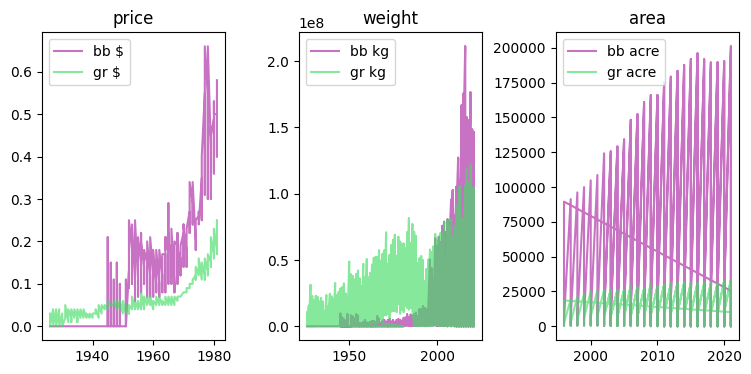

In [100]:
fig, (axa,axb,axc) = plt.subplots(1,3)
fig.set_size_inches(9, 4)

plot_value_year(df_bb,df_gr,axa,'$','price')
plot_value_year(df_bbkg,df_grkg,axb,'kg','weight')
plot_value_year(df_bbacre,df_gracre,axc,'acre','area')

plt.subplots_adjust(wspace=0.4,hspace=0.4)

### Understanding what the plots mean
The plots created above show different values for two commodities that we have selected. The `bb` acronym in the legend stands for blueberry, and the `gr` acronym stands for grapes. The first plot shows the price values in dollars, the second plot shows the weight values in kgs and the third plot shows the area values in acre. We can see that the blueberry plot clearly has higher curves than the grape plot. We can infer that over a decade and beyond, blueberry commodity has higher price, weight and area values as compared to the other commodity. This proves that certain commodities are produced more and have more price. This sort of preference is interesting, and for a business that wants to sell a particular commoditiy in a province - they can use this data, in order to create a fixed price at which they could sell the commodity. We wanted to understand this (price, weight, area) preference of commodity, as stated in the beginning of the project.

In [58]:
df_bb.groupby('GEO')['VALUE'].agg(np.mean).sort_values(ascending=False)[:5]

GEO
British Columbia    0.151964
Quebec              0.143750
Canada              0.136400
Nova Scotia         0.114107
New Brunswick       0.113393
Name: VALUE, dtype: float64

In [61]:
df_gr.groupby('GEO')['VALUE'].agg(np.mean).sort_values(ascending=False)[:5]

GEO
British Columbia    0.071964
Canada              0.055000
Ontario             0.053393
Name: VALUE, dtype: float64

## #5 Data Modeling

In [101]:
def model_data(df):
    '''
    data modeling using year, and geo categories
    for predicting value
    '''
    y = df['VALUE']
    Xcat = pd.get_dummies(df[['GEO']],dummy_na=False,drop_first=False)
    X = pd.concat([ df['REF_DATE'],Xcat ],axis=1)
    lr_model = LinearRegression().fit(X.values, y.values)
    plt.barh(X.columns,lr_model.coef_)
    return lr_model

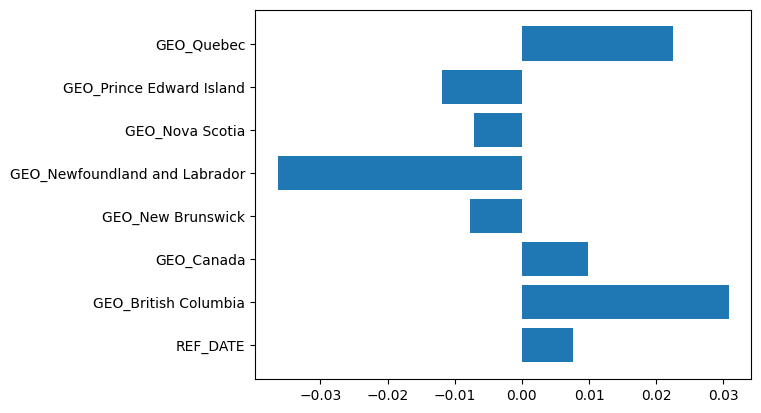

In [102]:
bb_price_model = model_data(df_bb)

### Understanding what the plot means
The plot created above is used to interpret the correlation coefficient for different attributes. We see how some attributes have highly positive values for the coefficients, while others are negative. Some values are the in-betweens. In the plot above, we see that the geo value for BC has the highest coefficient. If a value has highly positive coefficient, it means that it has a strong influence in the model when the `predict` function is called. Please note that this is merely an interpretation. The final evaluation is what we rely on. The visualization above helps us with an overview of a set of attributes that are used to create the model.

## #6 Evaluation

To evaluate we work with the price data, here we use dictionary as inputs comprising
of year and geo values, then using `bb_price_model` as our model we `predict` the prices
and visualize the data towards the end

In [103]:
priceInCanada2025 = {
    'REF_DATE':2025,
    'GEO_British Columbia':0,
    'GEO_Canada':1,
    'GEO_New Brunswick':0,
    'GEO_Newfoundland and Labrador':0,
    'GEO_Nova Scotia':0,
    'GEO_Prince Edward Island':0,
    'GEO_Quebec':0
}
priceInNewBrunswick2025 = {
    'REF_DATE':2025,
    'GEO_British Columbia':0,
    'GEO_Canada':0,
    'GEO_New Brunswick':1,
    'GEO_Newfoundland and Labrador':0,
    'GEO_Nova Scotia':0,
    'GEO_Prince Edward Island':0,
    'GEO_Quebec':0
}
priceInBC2025 = {
    'REF_DATE':2025,
    'GEO_British Columbia':1,
    'GEO_Canada':0,
    'GEO_New Brunswick':0,
    'GEO_Newfoundland and Labrador':0,
    'GEO_Nova Scotia':0,
    'GEO_Prince Edward Island':0,
    'GEO_Quebec':0
}

In [104]:
inputList = list(priceInCanada2025.values())
priceInCanada2025_result = bb_price_model.predict(np.array(inputList).reshape(1,-1))

inputList = list(priceInNewBrunswick2025.values())
priceInNewBrunswick2025_result = bb_price_model.predict(np.array(inputList).reshape(1,-1))

inputList = list(priceInBC2025.values())
priceInBC2025_result = bb_price_model.predict(np.array(inputList).reshape(1,-1))

### Understanding what the plot means

The plot below shows that the average price in Canada lies in between the price in New Brunswick and BC. And the price in BC is higher than all other prices. Please note that this is not a business understanding rather a fact we wanted to confirm.

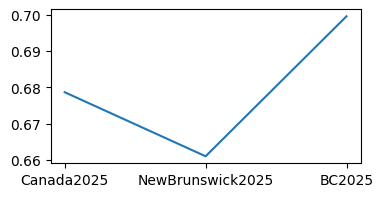

In [105]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(4, 2)
ax.plot(['Canada2025','NewBrunswick2025','BC2025'],
        [priceInCanada2025_result[0],
         priceInNewBrunswick2025_result[0],
         priceInBC2025_result[0]])